# Medical image segmentation with point-based prompts (Inference; Experimental Functionality)

In this tutorial, we will show how to use point prompts for medical image segmentation. We also used the [MICCAI FLARE 2022](https://zenodo.org/record/7860267) dataset as an example.
Assume that you have trained the model following the [training pipeline](https://github.com/bowang-lab/MedSAM/tree/main/extensions/point_prompt). If not, you can use this [checkpoint](https://drive.google.com/file/d/1gAhsHwE-MIs0OuGAe6dcJugxvz6fdWFq/view?usp=sharing). 

In [1]:
#!pip install git+https://github.com/bowang-lab/MedSAM.git

In [4]:
%matplotlib widget
from segment_anything import sam_model_registry
from os.path import join, isfile, basename
from os import getcwd
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from torch.nn import functional as F
import cv2
import torch
import numpy as np
import gc
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

## Define point prompt inference pipeline and GUI

The whole inference pipeline is the same as the bounding box-based version. The only difference is that the prompt encoder will accept point inputs.

In [2]:
class PointPromptDemo:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None
        

    def show_mask(self, mask, ax, random_color=False, alpha=0.95):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
        else:
            color = np.array([251/255, 252/255, 30/255, alpha])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    @torch.no_grad()
    def infer(self, x, y):
        coords_1024 = np.array([[[
            x * 1024 / self.img_size[1],
            y * 1024 / self.img_size[0]
        ]]])
        coords_torch = torch.tensor(coords_1024, dtype=torch.float32).to(self.model.device)
        labels_torch = torch.tensor([[1]], dtype=torch.long).to(self.model.device)
        point_prompt = (coords_torch, labels_torch)

        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points = point_prompt,
            boxes = None,
            masks = None,
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings=self.image_embeddings, # (B, 256, 64, 64)
            image_pe=self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        )

        low_res_probs = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
        low_res_pred = F.interpolate(
            low_res_probs,
            size = self.img_size,
            mode = 'bilinear',
            align_corners = False
        )
        low_res_pred = low_res_pred.detach().cpu().numpy().squeeze()

        seg = np.uint8(low_res_pred > 0.5)

        return seg

    def show(self, fig_size=5, alpha=0.95, scatter_size=10):

        assert self.image is not None, "Please set image first."
        seg = None
        fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.toolbar_visible = False
        fig.canvas.resizable = False

        plt.tight_layout()

        ax.imshow(self.image)
        ax.axis('off')

        def onclick(event):
            if event.inaxes == ax:
                x, y = float(event.xdata), float(event.ydata)
                with torch.no_grad():
                    ## rescale x, y from canvas size to 1024 x 1024
                    seg = self.infer(x, y)

                ax.clear()
                ax.imshow(self.image)
                ax.axis('off')
                ax.scatter(x, y, c='r', s=scatter_size)
                self.show_mask(seg, ax, random_color=False, alpha=alpha)

                gc.collect()

        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

        save_button = widgets.Button(description="save")
        def __on_save_button_clicked(b):
            plt.savefig("seg_result.png", bbox_inches='tight', pad_inches=0)
            if seg is not None:
                cv2.imwrite("seg.png", seg)
                print(f"Segmentation result saved to {getcwd()}")

        display(save_button)
        save_button.on_click(__on_save_button_clicked)

    def set_image(self, image):
        self.img_size = image.shape[:2]
        if len(image.shape) == 2:
            image = np.repeat(image[:,:,None], 3, -1)
        self.image = image
        image_preprocess = self.preprocess_image(self.image)
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_preprocess)
        
    def preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_CUBIC
        )
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) # normalize to [0, 1], (H, W, 3
        # convert the shape to (3, H, W)
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor
    

## Load pre-trained model

In [3]:
medsam_ckpt_path = "/hpc/group/yizhanglab/zs144/resources/MedSAM/original_ckpt/medsam_point_prompt_flare22.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=medsam_ckpt_path)
medsam_model = medsam_model.to(device)
medsam_model.eval()
point_prompt_demo = PointPromptDemo(medsam_model)

/hpc/group/yizhanglab/zs144/repo/Zion-MedSAM/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.d

## Load data and run inference

This point prompt-based segmentation model was trained on FALRE22 dataset. So it can only segment these 13 organs: liver, right kidney, spleen, pancreas, aorta, inferior vena cava, right adrenal gland, left adrenal gland, gallbladder, esophagus, stomach, duodenum, and left kidney. 

![demo](point_seg_demo.gif)

In [12]:
# load demo nii data
image = Image.open("/hpc/group/yizhanglab/zs144/Zion-ZhangLab/public/data/neurons_wsi/test_patches/240819_Ji_N1_H_EScan/patch_6_6.png")
# # adjust window width and level
# lower_bound = -240.0
# upper_bound = 160.0
# image_data_pre = np.clip(image_data, lower_bound, upper_bound)
# # normalize to [0, 255]
# image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
# image_data_pre = np.uint8(image_data_pre)
# # select middle slice; you can also manually select the slice that you want to test
# image_slice_id = int(image_data_pre.shape[0]/2)
# image_slice = image_data_pre[image_slice_id]
# # show the image to check whether it contains abdominal organs
# plt.imshow(np.rot90(image_slice, 2), cmap='gray')

Text(0.5, 1.0, 'Patch (6, 6)')

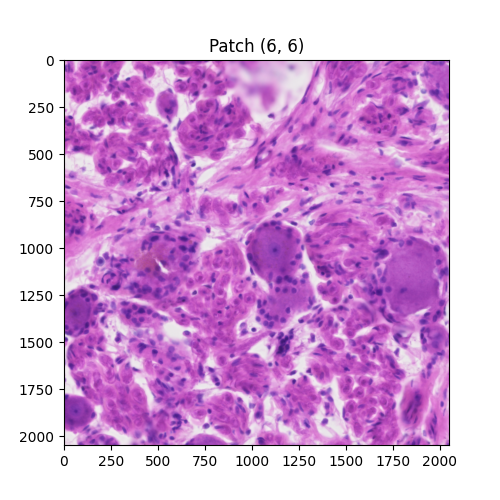

In [15]:
img = np.array(image)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title('Patch (6, 6)')

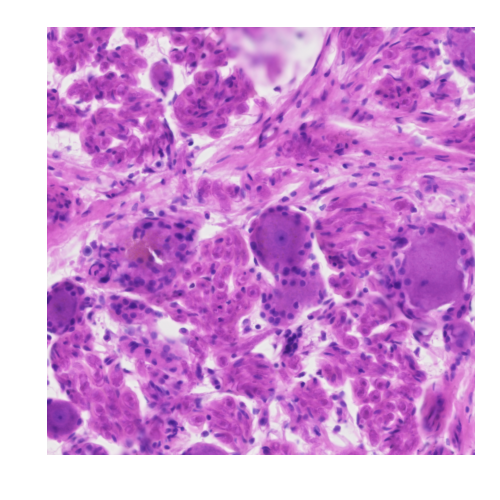

Button(description='save', style=ButtonStyle())

In [16]:
point_prompt_demo.set_image(img)
point_prompt_demo.show()

## Closing remarks

This is still an experimental function at present. There is a large room for further improvements, such as incorporating background points for interactive error corrections. 